# Generating images with MX-Font model from a reference style
In this example we'll generate images with trained MX-Font model from a reference style.
If you want to generate multiple styles, please check using `eval.py` instead of using this example file (because it is much simpler to load the referece styles).

### 1. Loading packages
* First, load the packages used in this code.
* All of the packages are avilable in `pip`.

In [1]:
import json
from pathlib import Path
from PIL import Image

import torch
from sconf import Config
from torchvision import transforms

import os
import cv2
import math
import matplotlib.pyplot as plt

* These modules are defined in this repository.

In [2]:
import models
from datasets import read_font, render
from utils import save_tensor_to_image

### 2. Define Inference Handler Class

In [3]:
class InferenceHandler:
    
    def __init__(self, weight_path, default_cfg):
        self.weight_path = weight_path
        self.default_cfg = default_cfg

    def build_model(self):
        '''
        Build and load the trained model.
        '''
        cfg = Config("cfgs/eval.yaml", default=self.default_cfg)
        self.transform = transforms.Compose(
            [transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        )
        self.decomposition = json.load(open("data/chn_decomposition.json"))

        g_kwargs = cfg.get('g_args', {})
        self.gen = models.Generator(1, cfg.C, 1, **g_kwargs).cuda().eval()
        weight = torch.load(self.weight_path)
        if "generator_ema" in weight:
            weight = weight["generator_ema"]
        self.gen.load_state_dict(weight)

    def load_reference_images(self, data_path, exp_path):
        '''
        Load reference images
        '''
        self.data_path = data_path
        self.exp_path =  exp_path

        # Get a list of image files in the 'data/' folder
        image_files = os.listdir(f'{self.data_path}')

        print(image_files)

        # Image Preprocessing: Loop through each image file
        for image_file in image_files:
            if image_file.endswith(('.jpg', '.png', '.jpeg')):  # Only process image files
                # Load the image
                image_path = os.path.join(self.data_path, image_file)
                image = cv2.imread(image_path)

                # Convert to grayscale
                grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                # # Denoise the Image
                # denoised_image = cv2.fastNlMeansDenoising(grayscale_image, None, h=10, templateWindowSize=7, searchWindowSize=21)

                # Create save directory
                self.raw_imgs_path = f'{self.exp_path}/raw_imgs'
                self.ref_imgs_path = f'{self.exp_path}/ref_imgs'
                if not os.path.exists(self.raw_imgs_path): os.makedirs(self.raw_imgs_path)
                if not os.path.exists(self.ref_imgs_path): os.makedirs(self.ref_imgs_path)

                # Save the grayscale image in the 'result' folder
                raw_img = os.path.join(self.raw_imgs_path, image_file)
                ref_img = os.path.join(self.ref_imgs_path, image_file)
                cv2.imwrite(raw_img, image)
                cv2.imwrite(ref_img, grayscale_image)

                print(f'Converted {image_file} and saved as {ref_img}')

        print(f'Done!!')

    def extract_style_factor(self):
        '''
        * `ref_path`: 
            * The path of reference font or images.
            * If you are using a ttf file, set this to the location of the ttf file.
            * If you want to use rendered images, set this to the path to the directory which contains the reference images.
        * `extension`:
            * If you are using image files, set this to their extension(png, jpg, etc..). 
            * This will be ignored if `use_ttf` is True.
        * `batch_size`:
            * The number of images inferred at once.
        '''
        ref_path = self.ref_imgs_path  # Path to the reference images
        extension = "png"  # Extension of the reference images
        batch_size = 3  # The batch size

        ref_paths = Path(ref_path).glob(f"*.{extension}")
        ref_imgs = torch.stack([self.transform(Image.open(str(p))) for p in ref_paths]).cuda()
        ref_batches = torch.split(ref_imgs, batch_size)

        self.style_facts = {}

        for batch in ref_batches:
            style_fact = self.gen.factorize(self.gen.encode(batch), 0)
            for k in style_fact:
                self.style_facts.setdefault(k, []).append(style_fact[k])
                
        self.style_facts = {k: torch.cat(v).mean(0, keepdim=True) for k, v in self.style_facts.items()}

    def generate_infer_imgs(self, gen_chars):
        save_dir = Path(f"{self.exp_path}/infer_imgs")  # Directory where you want to save generated images
        source_path = "data/ttfs/source/chn_source.ttf"  # Path to the font file to render the source images

        save_dir.mkdir(parents=True, exist_ok=True)
        source_font = read_font(source_path)

        self.gen_img_list = []
        for char in gen_chars:
            source_img = self.transform(render(source_font, char)).unsqueeze(0).cuda()
            char_facts = self.gen.factorize(self.gen.encode(source_img), 1)
            
            gen_feats = self.gen.defactorize([self.style_facts, char_facts])
            out = self.gen.decode(gen_feats).detach().cpu()[0]

            path = save_dir / f"{char}.png"
            self.gen_img_list.append(path)
            save_tensor_to_image(out, path)
        
        return self.gen_img_list

    def show_inference_imgs(self):
        images = []

        for filename in self.gen_img_list:
            img = cv2.imread(str(filename)) 
            if img is not None:
                images.append(img)

        plt.figure(figsize=(20,10))
        columns = 5
        for i, image in enumerate(images):
            plt.subplot(math.ceil(len(images) / columns + 1), columns, i + 1)
            plt.imshow(image)
        pass

### 3. Initialize the trained model.

In [4]:
# Initialization
ih_k1 = InferenceHandler(weight_path="generator_k1.pth", default_cfg="cfgs/defaults_k1.yaml")
ih_k1.build_model()

ih_k6 = InferenceHandler(weight_path="generator_k6.pth", default_cfg="cfgs/defaults_k6.yaml")
ih_k6.build_model()

### 4. Demonstrations and Experiments

### Exp.1 Same model configuration, different data

In [11]:
# Experiment1
data_path_1 = "data/images/group_by_complexity/complex/original"   # Path to the raw images
data_path_2 = "data/images/group_by_complexity/complex/processed"   # Path to the raw images
exp_path_k6  = "exp/YouSi_8shot_k6"                    # Path to the experiment folder
gen_chars = '床前明月光疑是地上霜举头望明月低头思故乡'

# Model(k=6) with original data
ih_k6.load_reference_images(data_path_1, exp_path_k6)
ih_k6.extract_style_factor()
ih_k6.generate_infer_imgs(gen_chars)
ih_k6.show_inference_imgs()

# # Model(k=6) with processed data
# ih_k6.load_reference_images(data_path_2, exp_path_k6)
# ih_k6.extract_style_factor()
# ih_k6.generate_infer_imgs(gen_chars)
# ih_k6.show_inference_imgs()

['240.png', '105.png', '137.png', '171.png', '59.png', '97.png', '20.png', '118.png']
Converted 240.png and saved as exp/YouSi_8shot_k6/ref_imgs/240.png
Converted 105.png and saved as exp/YouSi_8shot_k6/ref_imgs/105.png
Converted 137.png and saved as exp/YouSi_8shot_k6/ref_imgs/137.png
Converted 171.png and saved as exp/YouSi_8shot_k6/ref_imgs/171.png
Converted 59.png and saved as exp/YouSi_8shot_k6/ref_imgs/59.png
Converted 97.png and saved as exp/YouSi_8shot_k6/ref_imgs/97.png
Converted 20.png and saved as exp/YouSi_8shot_k6/ref_imgs/20.png
Converted 118.png and saved as exp/YouSi_8shot_k6/ref_imgs/118.png
Done!!


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 23.65 GiB of which 115.06 MiB is free. Process 123272 has 17.62 GiB memory in use. Including non-PyTorch memory, this process has 4.10 GiB memory in use. Of the allocated memory 3.54 GiB is allocated by PyTorch, and 107.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

['賢.png', '至.png', '咸.png', '畢.png', '集.png', '少.png', '長.png', '羣.png']
Converted 賢.png and saved as exp/YouSi_8shot_k1/ref_imgs/賢.png
Converted 至.png and saved as exp/YouSi_8shot_k1/ref_imgs/至.png
Converted 咸.png and saved as exp/YouSi_8shot_k1/ref_imgs/咸.png
Converted 畢.png and saved as exp/YouSi_8shot_k1/ref_imgs/畢.png
Converted 集.png and saved as exp/YouSi_8shot_k1/ref_imgs/集.png
Converted 少.png and saved as exp/YouSi_8shot_k1/ref_imgs/少.png
Converted 長.png and saved as exp/YouSi_8shot_k1/ref_imgs/長.png
Converted 羣.png and saved as exp/YouSi_8shot_k1/ref_imgs/羣.png
Done!!
['賢.png', '至.png', '咸.png', '畢.png', '集.png', '少.png', '長.png', '羣.png']
Converted 賢.png and saved as exp/YouSi_8shot_k6/ref_imgs/賢.png
Converted 至.png and saved as exp/YouSi_8shot_k6/ref_imgs/至.png
Converted 咸.png and saved as exp/YouSi_8shot_k6/ref_imgs/咸.png
Converted 畢.png and saved as exp/YouSi_8shot_k6/ref_imgs/畢.png
Converted 集.png and saved as exp/YouSi_8shot_k6/ref_imgs/集.png
Converted 少.png and saved as

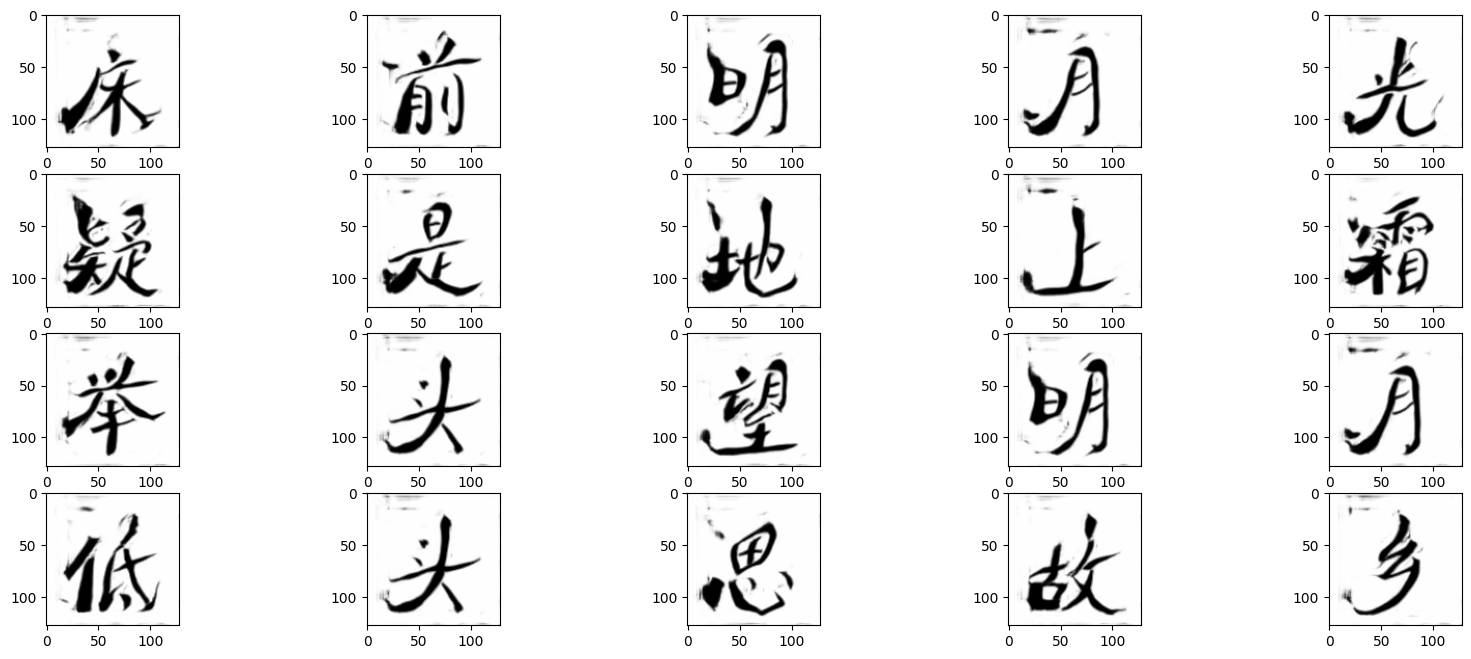

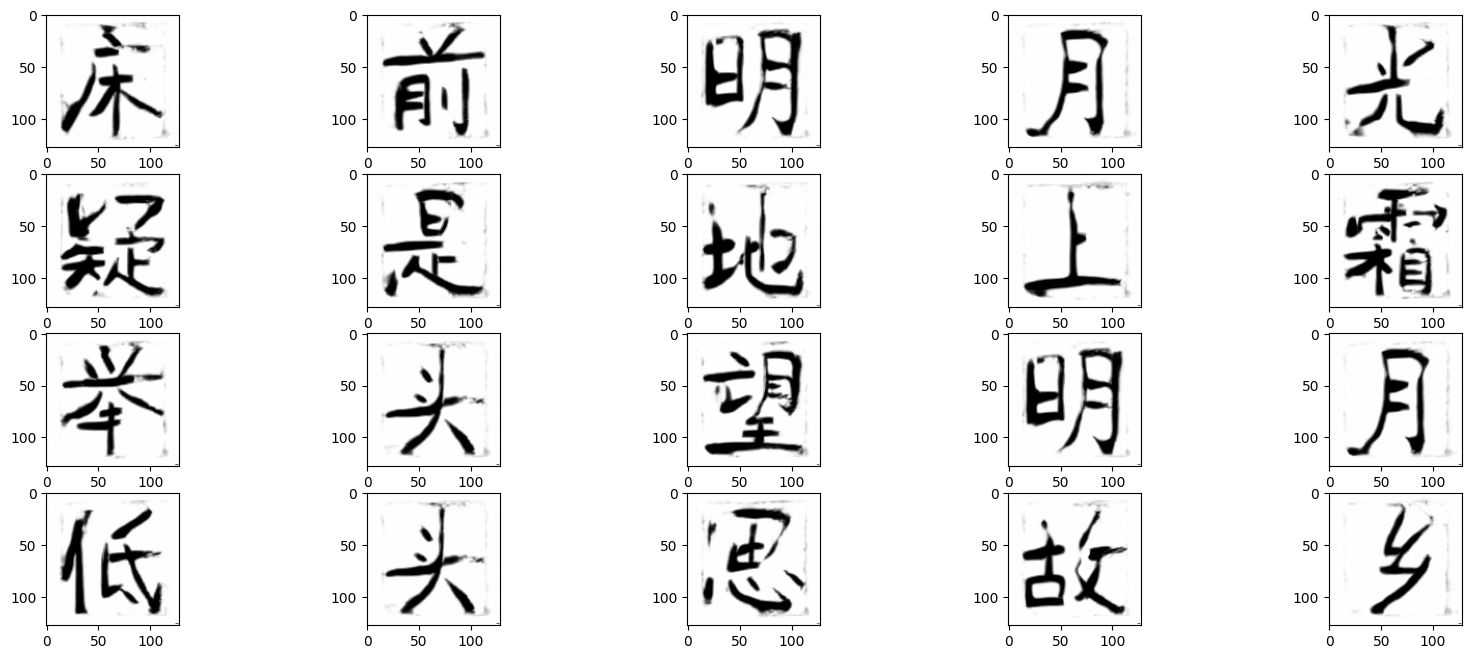

In [8]:
# Experiment1
data_path = "data/images/lanting/YouSi_8shot"   # Path to the raw images
exp_path_k1  = "exp/YouSi_8shot_k1"
exp_path_k6  = "exp/YouSi_8shot_k6"                    # Path to the experiment folder
gen_chars = '床前明月光疑是地上霜举头望明月低头思故乡'


# k=1
ih_k1.load_reference_images(data_path, exp_path_k1)
ih_k1.extract_style_factor()
ih_k1.generate_infer_imgs(gen_chars)
ih_k1.show_inference_imgs()

# k=6
ih_k6.load_reference_images(data_path, exp_path_k6)
ih_k6.extract_style_factor()
ih_k6.generate_infer_imgs(gen_chars)
ih_k6.show_inference_imgs()

['賢.png', '至.png', '咸.png', '畢.png', '集.png', '少.png', '長.png', '羣.png']
Converted 賢.png and saved as exp/YouSi_8shot/ref_imgs/賢.png
Converted 至.png and saved as exp/YouSi_8shot/ref_imgs/至.png
Converted 咸.png and saved as exp/YouSi_8shot/ref_imgs/咸.png
Converted 畢.png and saved as exp/YouSi_8shot/ref_imgs/畢.png
Converted 集.png and saved as exp/YouSi_8shot/ref_imgs/集.png
Converted 少.png and saved as exp/YouSi_8shot/ref_imgs/少.png
Converted 長.png and saved as exp/YouSi_8shot/ref_imgs/長.png
Converted 羣.png and saved as exp/YouSi_8shot/ref_imgs/羣.png
Done!!


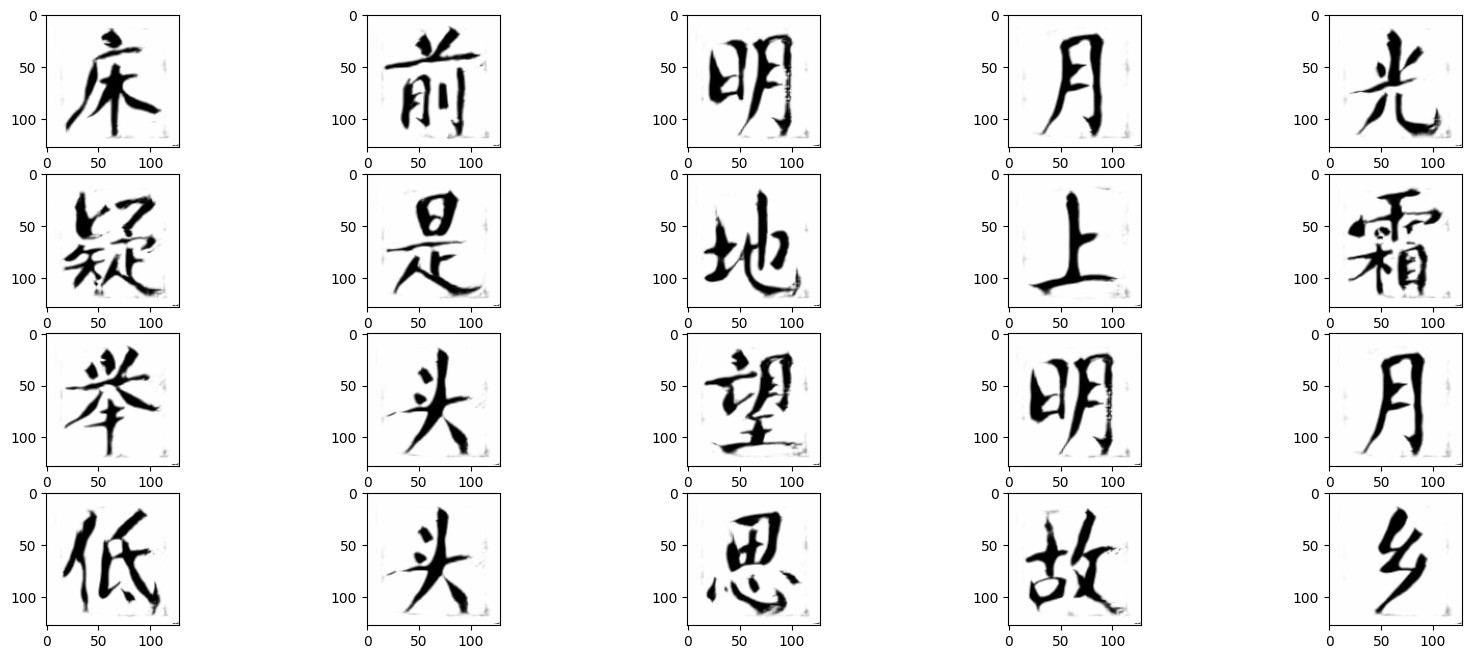

In [22]:
# Experiment1
data_path = "data/images/lanting/YouSi_8shot"   # Path to the raw images
exp_path  = "exp/YouSi_8shot"                   # Path to the experiment folder
gen_chars = '床前明月光疑是地上霜举头望明月低头思故乡'
ih.load_reference_images(data_path, exp_path)
ih.extract_style_factor()
ih.generate_infer_imgs(gen_chars)
ih.show_inference_imgs()